# Working Code

In [ ]:
import os
import pandas as pd
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import re  # Regular expressions for flexible pattern matching

# Set base data path
current_path = os.getcwd()  # Make paths relative to the current working directory
data_path = 'data'
brain_yolo9_dataset = 'BrainTumorDetectionYolov9/BrainTumorDetectionYolov9'
brain_yolo8_dataset = 'TumorDetectionYolov8/OD8/Brain Tumor Detection'

dataset_base_url = os.path.join(data_path, brain_yolo9_dataset)

# Predefined colors for labels (cycling colors if labels exceed this list)
label_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), 
                (255, 0, 255), (0, 255, 255), (128, 0, 128), (128, 128, 0)]


In [ ]:
def parse_data_yaml(yaml_path: str) -> dict:
    with open(yaml_path, 'r') as file:
        data_yaml = yaml.safe_load(file)
    return data_yaml

In [20]:
# Parse the data.yaml file
data_yaml_path = os.path.join(dataset_base_url, 'data.yaml')
data_yaml = parse_data_yaml(data_yaml_path)
print("Parsed data.yaml content:")
for key, value in data_yaml.items():
    print(f"{key}: {value}")

Parsed data.yaml content:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 3
names: ['label0', 'label1', 'label2']


In [87]:
def create_dataset_df(data_yaml_path: str, data_yaml: dict) -> pd.DataFrame:
    data_entries = []
    yaml_dir = data_yaml_path
    counts = {'train': {'images': 0, 'labels': 0},
              'val': {'images': 0, 'labels': 0},
              'test': {'images': 0, 'labels': 0}}

    # Lists to store unmatched images and labels
    images_without_labels = []
    labels_without_images = []
        
    for data_type in ['train', 'val', 'test']:
        if data_type in data_yaml:
            rel_image_path = data_yaml[data_type]
            image_dir = os.path.normpath(os.path.join(yaml_dir, rel_image_path))
            label_dir = image_dir.replace('images', 'labels')

            if not os.path.exists(image_dir):
                print(f"Image directory does not exist: {image_dir}")
                continue
            if not os.path.exists(label_dir):
                print(f"Label directory does not exist: {label_dir}")
                continue

            # Get all image and label files
            image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            label_files = [f for f in os.listdir(label_dir) if f.lower().endswith('.txt')]

            # Process each image file
            for image_file in image_files:
                # Absolute paths for image and label
                abs_image_path = os.path.join(image_dir, image_file)
                abs_label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
                
                # Increment image count
                counts[data_type]['images'] += 1

                # Check for label existence
                label_exists = os.path.exists(abs_label_path)
                if label_exists:
                    counts[data_type]['labels'] += 1
                else:
                    # Add to list if image has no corresponding label
                    images_without_labels.append(rel_image_path)

                # Make paths relative to the current working directory
                rel_image_path = os.path.relpath(abs_image_path, current_path)
                rel_label_path = os.path.relpath(abs_label_path, current_path) if label_exists else None

                # Regex to match "volume_<number>" and "slice_<number>"
                volume, slice_num = None, None
                volume_match = re.search(r'volume_(\d+)', image_file, re.IGNORECASE)
                slice_match = re.search(r'slice_(\d+)', image_file, re.IGNORECASE)
                
                if volume_match:
                    volume = volume_match.group(1)
                if slice_match:
                    slice_num = slice_match.group(1)

                # Generate unique ID based on the image file path and an incremental image ID
                unique_hash_id = hashlib.md5(rel_image_path.encode()).hexdigest()

                data_entries.append({
                    'type': data_type,
                    'image_path': rel_image_path,
                    'label_path': rel_label_path,
                    'volume': volume,
                    'slice': slice_num,
                    'id': unique_hash_id
                })


            # Check for labels without images
            for label_file in label_files:
                corresponding_image = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))
                if not os.path.exists(corresponding_image):
                    labels_without_images.append(os.path.join(label_dir, label_file))

    df = pd.DataFrame(data_entries)

    # Print counts for each data type
    for data_type, count in counts.items():
        print(f"{data_type.capitalize()} - Total Images: {count['images']}, Total Labels: {count['labels']}")

    # Print images without labels
    if images_without_labels:
        print("\nImages without labels:")
        for img in images_without_labels:
            print(f" - {img}")

    # Print labels without images
    if labels_without_images:
        print("\nLabels without images:")
        for lbl in labels_without_images:
            print(f" - {lbl}")

    return df, images_without_labels, labels_without_images


In [88]:
# Create the dataset DataFrame with relative paths and additional columns
dataset_df, images_without_labels, labels_without_images = create_dataset_df(data_yaml_path, data_yaml)

if dataset_df.empty:
    print("Dataset DataFrame is empty. Please check the dataset paths.")
else:
    display(dataset_df.head()) 

Train - Total Images: 6931, Total Labels: 6930
Val - Total Images: 1980, Total Labels: 1980
Test - Total Images: 990, Total Labels: 990

Images without labels:
 - BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/volume_244_slice_53_jpg.rf.21e910587f9329e96fa00056018c1eb1.jpg


,type,image_path,label_path,volume,slice,id
0,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,46,61,508ff881e6ee8c6010f040a98e0b6ffa
1,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,198,79,cfbafb37ece154765249a28b00272560
2,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,323,31,5ec689cac88f4ad262d8648b7d94afd4
3,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,151,60,d7f202943c6646502c6ef087781629a5
4,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,320,105,764366c3d1640db6cfc0a55e6ee23a55


In [ ]:
dataset_df['volume'] = dataset_df['volume'].astype(int)
dataset_df['slice'] = dataset_df['slice'].astype(int)

## Understanding Slices

### Frequency of Slices

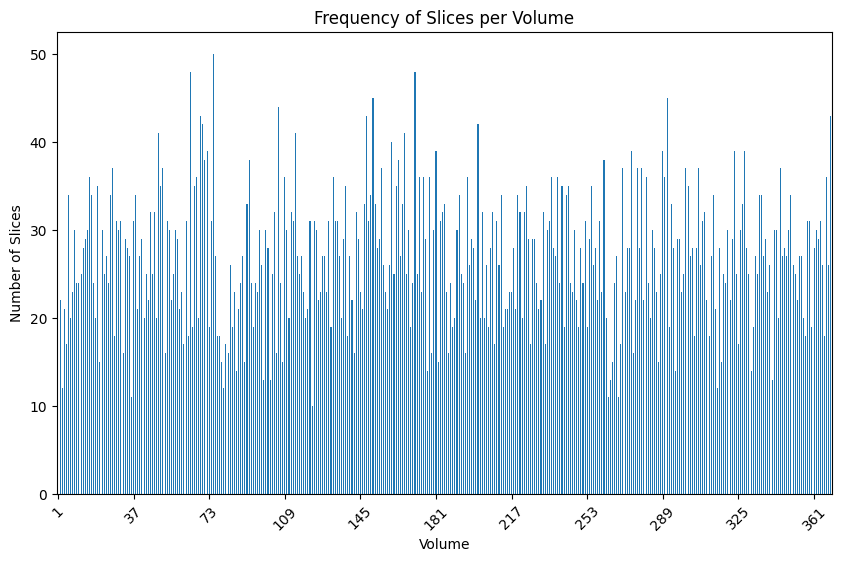

In [80]:
# Function to plot the frequency of slices for a specific volume or all volumes
import matplotlib.pyplot as plt

def plot_slice_frequency(df: pd.DataFrame, volume_number: int = None) -> None:
    # Count the number of slices per volume
    slice_counts = df.groupby('volume')['slice'].nunique()

    # If a specific volume number is provided, filter to that volume only
    if volume_number is not None:
        if volume_number in slice_counts.index:
            slice_counts = slice_counts.loc[[volume_number]]
            title = f"Frequency of Slices for Volume {volume_number}"
        else:
            print(f"Volume {volume_number} not found in the dataset.")
            return
    else:
        # If no specific volume, fill in missing volumes with 0 slices
        all_volumes = range(slice_counts.index.min(), slice_counts.index.max() + 1)
        slice_counts = slice_counts.reindex(all_volumes, fill_value=0)
        title = "Frequency of Slices per Volume"

    # Plot the slice frequency per volume
    plt.figure(figsize=(10, 6))
    slice_counts.plot(kind='bar')

    # Set title and labels
    plt.title(title)
    plt.xlabel("Volume")
    plt.ylabel("Number of Slices")
    plt.xticks(rotation=45)

    # Limit the number of x-ticks for readability
    if len(slice_counts) > 20:  # Adjust based on dataset size
        plt.xticks(ticks=range(0, len(slice_counts), len(slice_counts) // 10))

    plt.show()

plot_slice_frequency(dataset_df)

##### Frequency of Slices

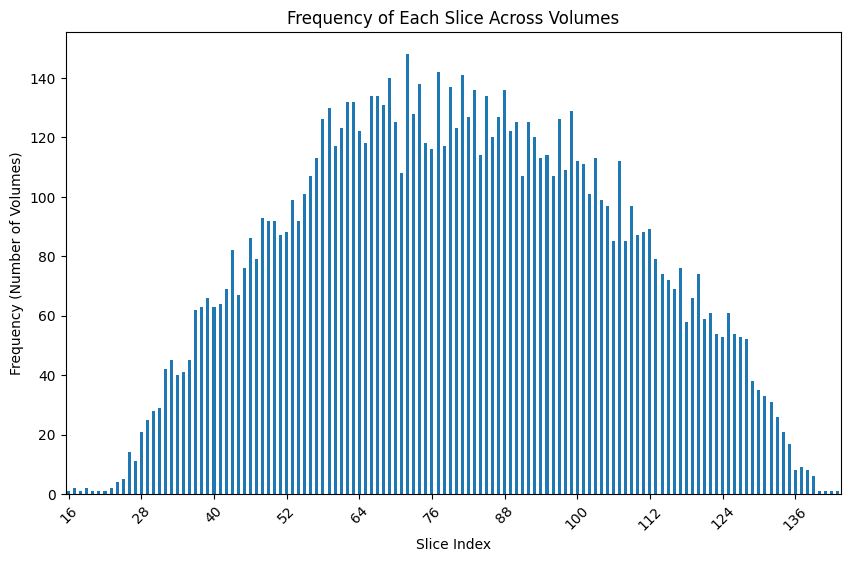

In [55]:

def plot_slice_occurrence_frequency(df: pd.DataFrame) -> None:
    # Count the occurrences of each slice across all volumes
    slice_occurrence_counts = df['slice'].value_counts().sort_index()

    # Plot the frequency of each slice
    plt.figure(figsize=(10, 6))
    slice_occurrence_counts.plot(kind='bar')

    # Set title and labels
    plt.title("Frequency of Each Slice Across Volumes")
    plt.xlabel("Slice Index")
    plt.ylabel("Frequency (Number of Volumes)")
    plt.xticks(rotation=45)

    # Limit the number of x-ticks for readability
    if len(slice_occurrence_counts) > 20:  # Adjust based on dataset size
        plt.xticks(ticks=range(0, len(slice_occurrence_counts), max(1, len(slice_occurrence_counts) // 10)))

    plt.show()

# Usage example:
plot_slice_occurrence_frequency(dataset_df)


### Order of Slices

Another thing we are trying to check is if it safe to delete the images without any labels.

In [86]:
# Function to count slices for a specific volume or all volumes if none specified
def count_slices_per_volume(df: pd.DataFrame, volume_number: int = None, detailed: bool = False) -> None:
    # Group by 'volume' and list all slices within each volume
    volume_groups = df.groupby('volume')['slice'].apply(list)
    slice_counts = df.groupby('volume')['slice'].nunique()

    if volume_number is not None:
        # Check if the specified volume exists in the dataset
        if volume_number in slice_counts.index:
            print(f"Volume {volume_number}: {slice_counts[volume_number]} slices")
            if detailed:
                print("Detailed slice numbers within this volume:")
                print(f" - Slices: {sorted(volume_groups[volume_number])}")
        else:
            print(f"Volume {volume_number} not found in the dataset.")
    else:
        # Print counts for all volumes if no specific volume is specified
        print("Number of slices within each volume:")
        for volume, count in slice_counts.items():
            print(f"Volume {volume}: {count} slices")
            if detailed:
                print(f" - Slices: {sorted(volume_groups[volume])}")
                print()  # Blank line for readability


# Print slice count for volume 46
count_slices_per_volume(dataset_df, volume_number=244, detailed = True)


Volume 244: 35 slices
Detailed slice numbers within this volume:
 - Slices: [41, 46, 47, 49, 53, 54, 55, 59, 62, 65, 72, 73, 76, 77, 79, 82, 83, 87, 89, 91, 92, 96, 97, 99, 101, 103, 104, 107, 109, 111, 113, 116, 117, 118, 121]


So if we delete "Images without labels", we should be fine, as the slices are not equadistance.

### Deleting the unneeded images:

In [91]:
# Display or handle unmatched files
print("Images to delete:", images_without_labels)
dataset_df = dataset_df[dataset_df['label_path'].notna()].reset_index(drop=True)


Images to delete: ['BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/volume_244_slice_53_jpg.rf.21e910587f9329e96fa00056018c1eb1.jpg']


`Breakpoint`

In [ ]:
# Run this cell
file_path = os.path.join(current_path, data_path,  'brain_tumor_detection_path_data.csv')

In [ ]:
# Saving in case if have to pull info. Run this cell to save
dataset_df.to_csv(file_path, index=False)


In [4]:
# Run this cell to read the data 
dataset_df = pd.read_csv(file_path)

## Data Visualization

In [93]:
def load_image(filepath: str, grayscale: bool = False, size= False) -> np.array:
    image = cv2.imread(filepath)
    
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {filepath}")

    # Convert to grayscale if specified
    if grayscale:
        image = convert_to_grayscale(image)
    
    if size:
        return cv2.resize(image, size) 
    return image

def load_label(filepath: str) -> list:
    labels = []
    if not os.path.exists(filepath):
        return labels

    with open(filepath, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            label = {
                'class_id': int(parts[0]),
                'x_center': float(parts[1]),
                'y_center': float(parts[2]),
                'width': float(parts[3]),
                'height': float(parts[4]),
            }
            labels.append(label)
    return labels

def draw_labels(image: np.array, labels: list) -> np.array:
    image_h, image_w = image.shape[:2]

    for label in labels:
        class_id = label['class_id']
        x_center = label['x_center'] * image_w
        y_center = label['y_center'] * image_h
        width = label['width'] * image_w
        height = label['height'] * image_h

        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        color = label_colors[class_id % len(label_colors)]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        cv2.putText(image, f"Class {class_id}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    return image
import cv2
import numpy as np

def convert_to_grayscale(image: np.array) -> np.array:

    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_image_bgr = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)  # Convert grayscale back to BGR for consistency
    return grayscale_image_bgr

def display_images_in_notebook(image: np.array, labels: list, show_both: bool = True, figsize=(12, 6)):
    annotated_color_image = draw_labels(image.copy(), labels)
    
    if show_both:
        # Generate grayscale image with labels if both are to be shown
        grayscale_image = convert_to_grayscale(image)
        annotated_grayscale_image = draw_labels(grayscale_image.copy(), labels)
        
        # Display side by side
        plt.figure(figsize=figsize)
        
        # Display color image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_color_image, cv2.COLOR_BGR2RGB))
        plt.title("Color Image with Labels")
        plt.axis('off')
        
        # Display grayscale image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(annotated_grayscale_image, cv2.COLOR_BGR2RGB))
        plt.title("Grayscale Image with Labels")
        plt.axis('off')
        
        plt.show()
    else:
        # Display only color image if show_both is False
        plt.figure(figsize=(figsize[0] // 2, figsize[1]))
        plt.imshow(cv2.cvtColor(annotated_color_image, cv2.COLOR_BGR2RGB))
        plt.title("Image Image with Labels")
        plt.axis('off')
        plt.show()

import pandas as pd

def select_entry(dataset_df: pd.DataFrame, location):
    if dataset_df.empty:
        raise ValueError("Dataset is empty.")
    if location == "random":
        sample_entry = dataset_df.sample(n=1).iloc[0]
    else:
        if location < 0 or location >= len(dataset_df):
            raise IndexError("Location index out of range.")
        sample_entry = dataset_df.iloc[location]
    return {
        'image_path': sample_entry['image_path'],
        'label_path': sample_entry['label_path']
    }

def display_sample_entry(image_path: str, label_path: str, show_both=False, grayscale=False):
    print("\nSelected sample entry:")
    print(f"Image path: {image_path}")
    print(f"Label path: {label_path}")

    image = load_image(image_path, grayscale=grayscale)
    labels = load_label(label_path) if label_path else []
    display_images_in_notebook(image, labels, show_both=show_both)

def check_image(dataset_df, location="random", show_both=False, grayscale=False):
    try:
        sample_entry = select_entry(dataset_df, location)
        image_path = sample_entry['image_path']
        label_path = sample_entry['label_path']
        display_sample_entry(image_path, label_path, show_both=show_both, grayscale=grayscale)
    except (ValueError, IndexError) as e:
        print(e)




Selected sample entry:
Image path: BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/volume_25_slice_109_jpg.rf.d7f6efafbc604a469359493a59601f8b.jpg
Label path: BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/labels/volume_25_slice_109_jpg.rf.d7f6efafbc604a469359493a59601f8b.txt


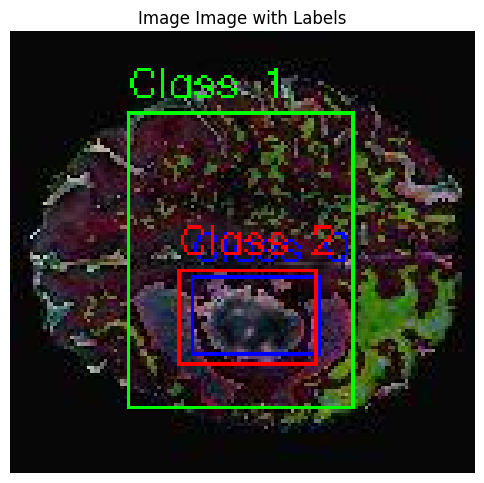

In [170]:
check_image(dataset_df)

### Want to check the image within grey scale as well


Selected sample entry:
Image path: BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/volume_87_slice_77_jpg.rf.9d34931fa6a819b251b6579931c1f0b3.jpg
Label path: BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/labels/volume_87_slice_77_jpg.rf.9d34931fa6a819b251b6579931c1f0b3.txt


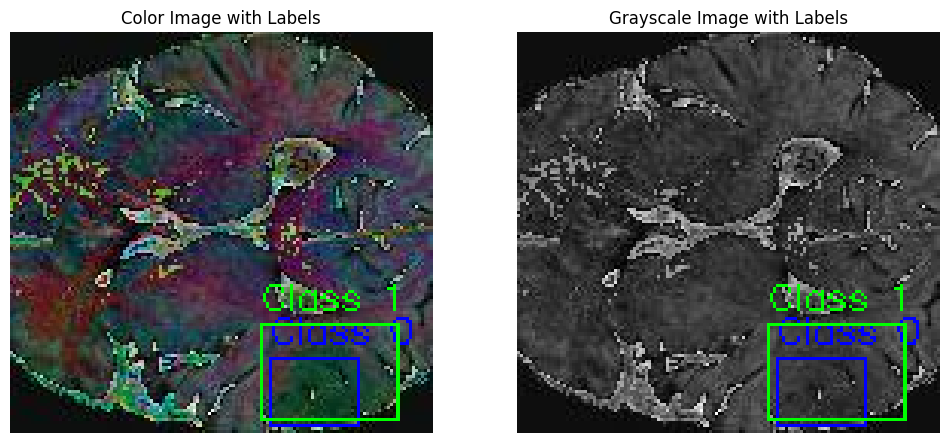

In [9]:
# Usage example:
check_image(dataset_df, show_both=True)


Color does seem to contain more information and at a glance it seems to be important

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Dropdown, FloatSlider
from IPython.display import display, clear_output

# --- Step 1: Reconstruct the 3D Volume from 2D Slices ---
def load_image(filepath: str) -> np.array:
    image = cv2.imread(filepath)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {filepath}")
    return image

def reconstruct_volume(dataset_df, volume_number):
    volume_df = dataset_df[dataset_df['volume'] == volume_number].sort_values(by='slice').reset_index(drop=True)
    slices = []
    for _, row in volume_df.iterrows():
        image_path = row['image_path']
        image = load_image(image_path)  # Load in color
        slices.append(image)
    volume = np.stack(slices, axis=0)  # Shape: (num_slices, height, width, channels)
    return volume, volume_df

# --- Step 2: Create the 3D Tumor Mask with Color Coding by Class ---
def load_label(filepath: str) -> list:
    labels = []
    if not os.path.exists(filepath):
        return labels
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                labels.append({
                    'class_id': int(parts[0]),
                    'x_center': float(parts[1]),
                    'y_center': float(parts[2]),
                    'width': float(parts[3]),
                    'height': float(parts[4])
                })
    return labels

def create_tumor_mask(volume_df, volume_shape):
    tumor_mask = np.zeros(volume_shape[:3], dtype=np.uint8)  # Only first three dimensions for mask (slices, height, width)
    class_masks = {}  # Dictionary to store masks for each class

    for slice_index, row in volume_df.iterrows():
        label_path = row['label_path']
        labels = load_label(label_path)
        for label in labels:
            class_id = label['class_id']
            x_center = label['x_center']
            y_center = label['y_center']
            width = label['width']
            height = label['height']
            img_height, img_width = volume_shape[1], volume_shape[2]
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img_width - 1, x2), min(img_height - 1, y2)
            
            # Initialize a mask for the current class if it doesn't exist
            if class_id not in class_masks:
                class_masks[class_id] = np.zeros(volume_shape[:3], dtype=np.uint8)
            # Set the bounding box area for the class mask
            class_masks[class_id][slice_index, y1:y2, x1:x2] = 1

    return tumor_mask, class_masks

# --- Step 3: Interactive Slice Visualization with Overlay, Resizing Option, and Legend ---
def display_slice(slice_index, show_overlay=True, image_size=10.0):
    mri_slice = volume[slice_index]
    
    # Prepare an overlay for each class
    overlay = mri_slice.copy()
    if show_overlay:
        for class_id, class_mask in class_masks.items():
            color = label_colors[class_id % len(label_colors)]  # Cycle through colors
            color_bgr = (color[2], color[1], color[0])  # Convert to BGR for OpenCV
            red_overlay = np.zeros_like(mri_slice)
            red_overlay[..., 0] = color[2]  # Red channel
            red_overlay[..., 1] = color[1]  # Green channel
            red_overlay[..., 2] = color[0]  # Blue channel
            alpha = 0.5
            mask_slice = class_mask[slice_index]
            overlay = np.where(mask_slice[..., None], 
                               (1 - alpha) * overlay + alpha * red_overlay, 
                               overlay)

    # Display the image with a legend
    plt.figure(figsize=(image_size, image_size))
    plt.imshow(cv2.cvtColor(overlay.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'Volume {selected_volume}, Slice {slice_index}')
    plt.axis('off')

    # Create a legend
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(color[0]/255, color[1]/255, color[2]/255), markersize=10, label=f'Class {class_id}')
                      for class_id, color in enumerate(label_colors) if class_id in class_masks]
    plt.legend(handles=legend_patches, loc='upper right', title="Classes")

    plt.show()

# --- Interactive Widgets and Execution ---
# Dropdown for selecting volume number, sorted in ascending order
unique_volumes = sorted(dataset_df['volume'].unique())
volume_dropdown = Dropdown(
    options=unique_volumes,
    value=unique_volumes[0],
    description='Select Volume:'
)

# Slider for controlling image size
size_slider = FloatSlider(
    value=10.0,
    min=5.0,
    max=20.0,
    step=0.5,
    description='Image Size:'
)

def update_volume(volume_number):
    global volume, volume_df, tumor_mask, class_masks, selected_volume, max_slice
    selected_volume = volume_number
    volume, volume_df = reconstruct_volume(dataset_df, volume_number)
    tumor_mask, class_masks = create_tumor_mask(volume_df, volume.shape)
    max_slice = volume.shape[0] - 1
    
    # Clear the output to remove the previous interactive widget
    clear_output(wait=True)
    
    # Recreate the slice slider with the updated max_slice value
    slice_slider = IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice Index')

    # Display the dropdown, size slider, and the interactive widget
    display(volume_dropdown)
    display(interactive(display_slice, 
             slice_index=slice_slider,
             show_overlay=True,
             image_size=size_slider))

# Set initial values
selected_volume = volume_dropdown.value
volume, volume_df = reconstruct_volume(dataset_df, selected_volume)
tumor_mask, class_masks = create_tumor_mask(volume_df, volume.shape)
max_slice = volume.shape[0] - 1

# Display dropdown, size slider, and initial interactive slider
volume_dropdown.observe(lambda change: update_volume(change.new), names='value')
display(volume_dropdown)
display(interactive(display_slice, 
         slice_index=IntSlider(min=0, max=max_slice, step=1, value=0),
         show_overlay=True,
         image_size=size_slider))


Dropdown(description='Select Volume:', index=14, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…

interactive(children=(IntSlider(value=0, description='Slice Index', max=29), Checkbox(value=True, description=…

Question to answer: Do all the slice numbers (not index) contain the same subsection of the brain?

In [ ]:

def display_slice_comparisons(dataset_df, slice_number, top_n=6):
    # Filter dataset to only include the specified slice number
    slice_df = dataset_df[dataset_df['slice'] == slice_number]
    
    # Sort the filtered DataFrame by volume, then pick the top `n` images from this slice
    top_slice_images = slice_df.sort_values(by='volume').head(top_n)
    
    # Determine the number of rows needed (3 images per row)
    n_cols = 3
    n_rows = math.ceil(top_n / n_cols)
    
    # Plot images in a grid with a max of 3 images per row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the height as needed

    # Flatten axes if only one row of subplots is created
    if n_rows == 1:
        axes = np.array([axes]) if isinstance(axes, plt.Axes) else axes  # Ensure axes is an array
        axes = axes.flatten()

    for i, (_, row) in enumerate(top_slice_images.iterrows()):
        # Load the image
        image_path = row['image_path']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display with matplotlib

        # Find the row and column index
        row_idx = i // n_cols
        col_idx = i % n_cols

        # Display image in the appropriate subplot
        if n_rows == 1:
            axes[col_idx].imshow(image)
            axes[col_idx].set_title(f"Volume {row['volume']}, Slice {row['slice']}")
            axes[col_idx].axis('off')
        else:
            axes[row_idx, col_idx].imshow(image)
            axes[row_idx, col_idx].set_title(f"Volume {row['volume']}, Slice {row['slice']}")
            axes[row_idx, col_idx].axis('off')

    # Hide any unused subplots if top_n is not a multiple of 3
    for j in range(i + 1, n_rows * n_cols):
        if n_rows == 1:
            axes[j].axis('off')
        else:
            row_idx = j // n_cols
            col_idx = j % n_cols
            axes[row_idx, col_idx].axis('off')
        
    plt.tight_layout()
    plt.show()

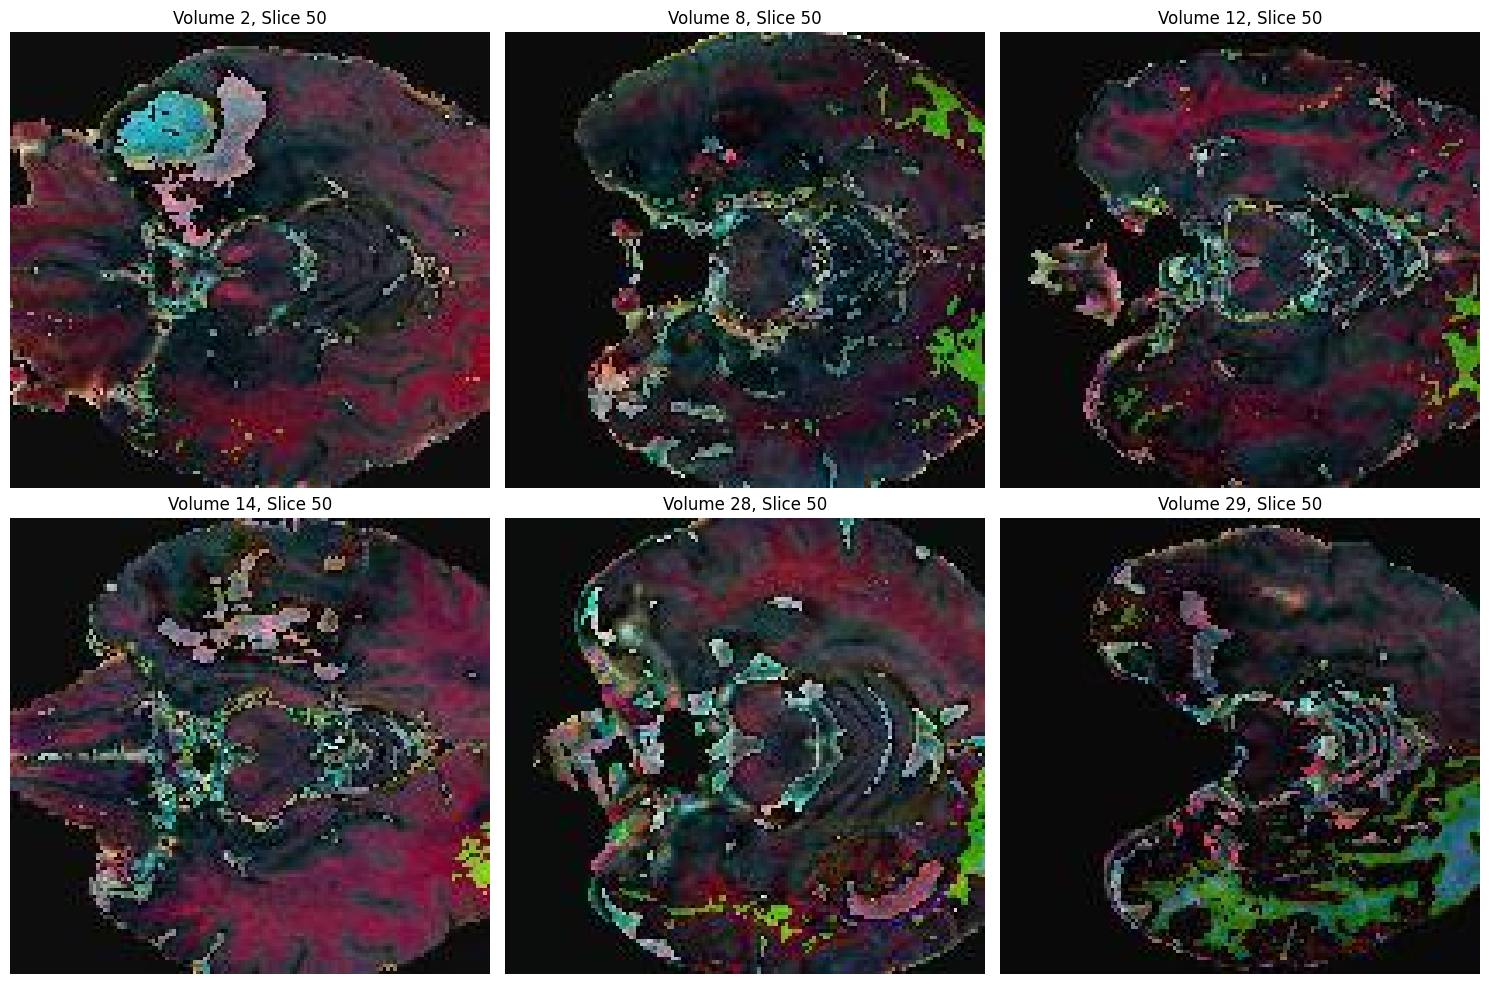

In [68]:
display_slice_comparisons(dataset_df, slice_number = 50, top_n= 6)


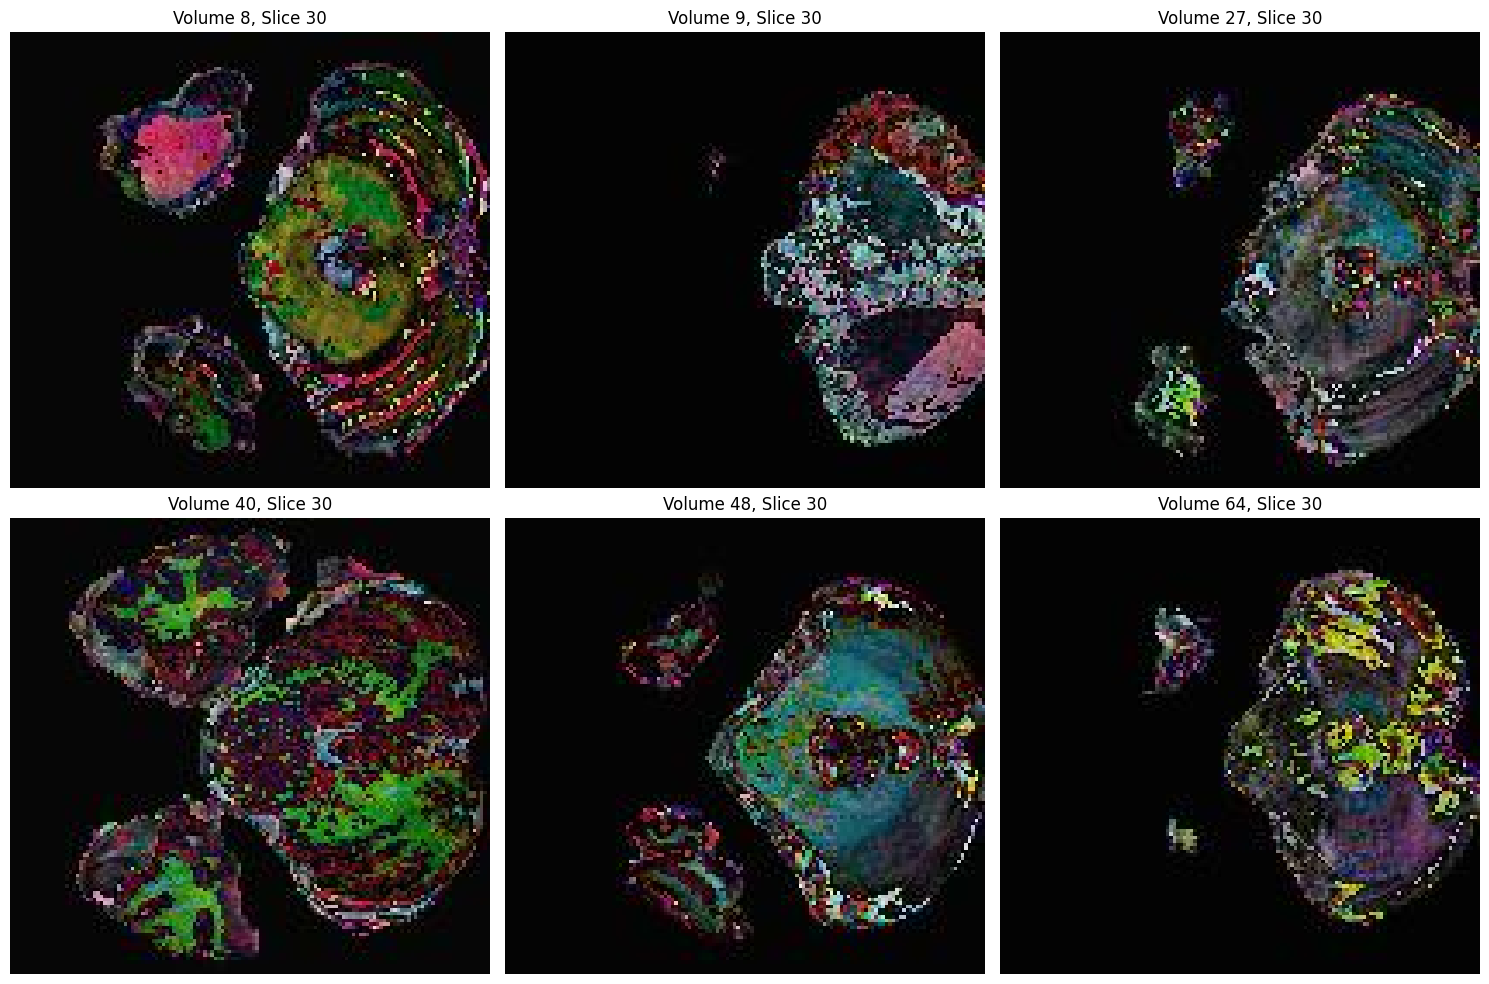

In [72]:
display_slice_comparisons(dataset_df, slice_number = 30, top_n= 6)


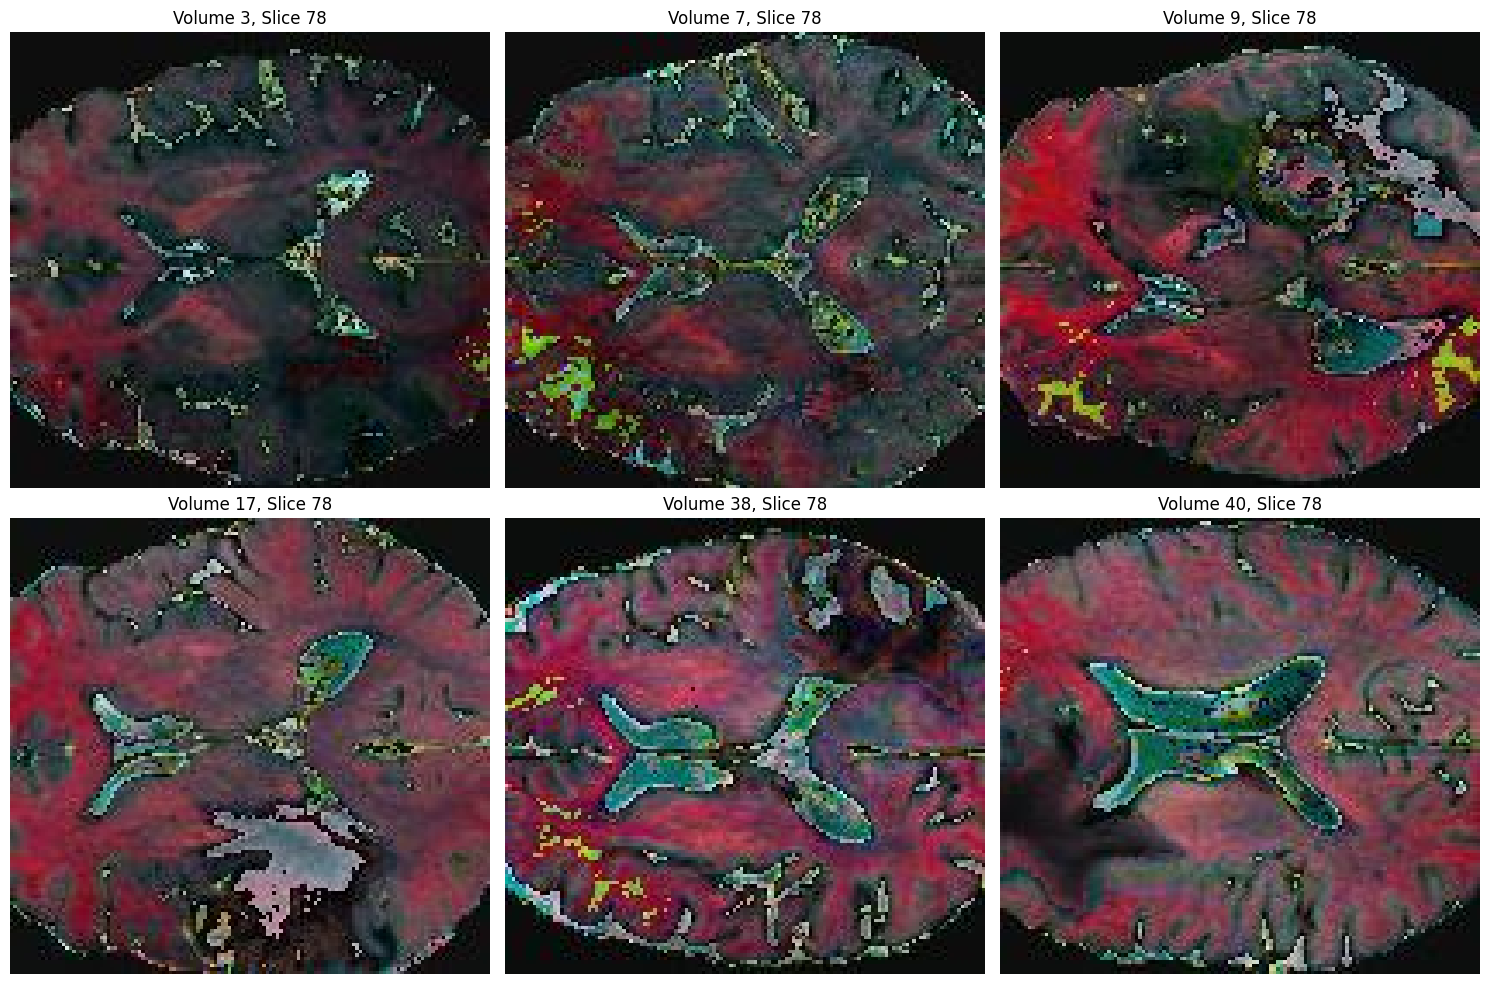

In [73]:
display_slice_comparisons(dataset_df, slice_number = 78, top_n= 6)


There does seem to be a similarity within same `slice_number`, but one issue is the distribution of frequency of Slices can intruduce some bias. 

Analysis Summary:
  Average SSIM: 0.0745 (Std Dev: 0.1601)
  Average Histogram Similarity: 0.3342 (Std Dev: 0.3304)


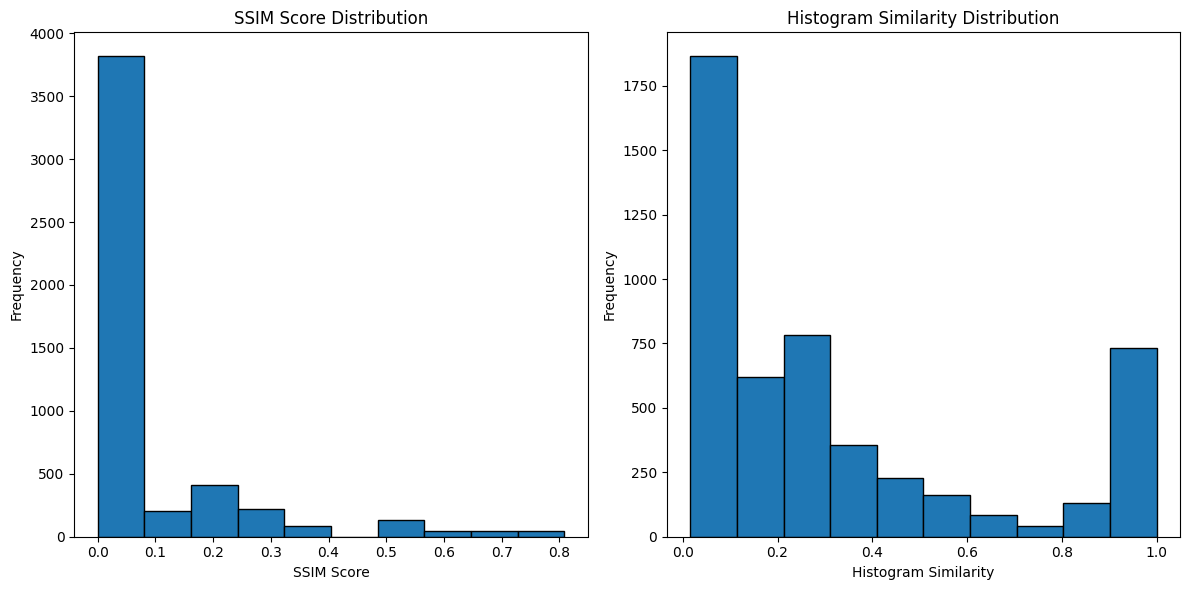

In [126]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import itertools

def calculate_ssim(image1, image2):
    return ssim(image1, image2)

def calculate_histogram_similarity(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    return pearsonr(hist1, hist2)[0]  # Returns the Pearson correlation coefficient

def analyze_random_slices_for_brain_subsections(dataset_df, num_samples=500, downsample_size=False, ssim_threshold=0.5):
    ssim_scores = []
    hist_scores = []
    unique_slices = dataset_df['slice'].unique().tolist()
    
    while len(ssim_scores) < num_samples:
        slice_number = random.choice(unique_slices)
        slice_df = dataset_df[dataset_df['slice'] == slice_number]
        image_paths = slice_df['image_path'].tolist()
        
        if len(image_paths) < 2:
            continue

        images = [cv2.cvtColor(load_image(path, size=downsample_size), cv2.COLOR_BGR2GRAY) for path in image_paths[:2]]
        
        hist_score = calculate_histogram_similarity(images[0], images[1])
        
        if hist_score > ssim_threshold:
            ssim_score = calculate_ssim(images[0], images[1])
            ssim_scores.append(ssim_score)
            hist_scores.append(hist_score)
        else:
            ssim_scores.append(0)  # Mark as low similarity
            hist_scores.append(hist_score)
    
    # Calculate statistics for the scores
    avg_ssim = np.mean(ssim_scores)
    std_ssim = np.std(ssim_scores)
    avg_hist = np.mean(hist_scores)
    std_hist = np.std(hist_scores)
    
    print("Analysis Summary:")
    print(f"  Average SSIM: {avg_ssim:.4f} (Std Dev: {std_ssim:.4f})")
    print(f"  Average Histogram Similarity: {avg_hist:.4f} (Std Dev: {std_hist:.4f})")

    # Plotting the distribution of similarity scores
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(ssim_scores, bins=10, edgecolor='black')
    plt.title("SSIM Score Distribution")
    plt.xlabel("SSIM Score")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(hist_scores, bins=10, edgecolor='black')
    plt.title("Histogram Similarity Distribution")
    plt.xlabel("Histogram Similarity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example usage
analyze_random_slices_for_brain_subsections(dataset_df, num_samples=5000)


The analysis indicates that the slices likely represent different subsections of the brain rather than a consistent, single region. The low average SSIM (0.0745) and high variability in both SSIM and histogram similarity scores suggest substantial structural and intensity differences between slices. The distribution of scores, with most values concentrated near zero, further supports the conclusion that these slices capture varying anatomical sections rather than the same subsection across different slice numbers.

NOT SURE ABOUT THIS YET:

However, given that the scores are low and highly variable, they might need to be combined with other robust features to improve predictive power. Therefore, while these scores could offer some additional context, relying solely on them might not yield significant insights, and their inclusion would likely be more valuable as part of a broader feature set.

In [ ]:
# Pulling information for each in
dataset_df.head()

,type,image_path,label_path,volume,slice,id
0,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,46,61,508ff881e6ee8c6010f040a98e0b6ffa
1,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,198,79,cfbafb37ece154765249a28b00272560
2,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,323,31,5ec689cac88f4ad262d8648b7d94afd4
3,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,151,60,d7f202943c6646502c6ef087781629a5
4,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,BrainTumorDetectionYolov9/BrainTumorDetectionY...,320,105,764366c3d1640db6cfc0a55e6ee23a55


In [130]:
# Add a new column 'class_nums' to store the number of unique classes for each label
dataset_df['class_nums'] = dataset_df['label_path'].apply(
    lambda path: len(set(int(line.split()[0]) for line in open(path) if os.path.exists(path)))
)

# Find the maximum number of unique classes across all label files
max_class_count = dataset_df['class_nums'].max()
print(f"Maximum number of unique classes across all labels: {max_class_count}")



Maximum number of unique classes across all labels: 3


In [140]:
from tqdm import tqdm  # Import tqdm for the progress bar

# Initialize an empty list to collect each row as a dictionary
expanded_rows = []

# Loop through each image entry in the dataset with tqdm progress bar
for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc="Processing images"):
    image_path = row['image_path']
    label_path = row['label_path']
    volume = row['volume']
    slice_num = row['slice']
    data_category = row['type']
    
    # Check if label file exists and proceed if it does
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            lines = file.readlines()
            # For each class label line, extract details and add a new row to expanded_rows
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # Skip malformed lines
                
                # Parse the class information and bounding box data
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                # Create a dictionary representing a single row for this class
                row_data = {
                    'data_category': data_category,
                    'image_path': image_path,
                    'volume': volume,
                    'slice': slice_num,
                    'class_id': class_id,
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height,
                }
                
                # Append the row data to expanded_rows
                expanded_rows.append(row_data)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)


Processing images: 100%|██████████| 9900/9900 [00:00<00:00, 12449.98it/s]


In [141]:
# Add one-hot encoded columns for each class (outside the main loop)
for cid in range(max_class_count + 1):
    expanded_df[f'class_{cid}'] = (expanded_df['class_id'] == cid).astype(int)

# Display the expanded DataFrame
print("Expanded DataFrame with one row per class and bounding box details:")
display(expanded_df.head())

Expanded DataFrame with one row per class and bounding box details:


,data_category,image_path,volume,slice,class_id,x_center,y_center,width,height,class_0,class_1,class_2,class_3
0,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,46,61,1,0.428058,0.674242,0.525180,0.318182,0,1,0,0
1,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,198,79,0,0.467626,0.219697,0.187050,0.151515,1,0,0,0
2,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,198,79,1,0.500000,0.219697,0.467626,0.393939,0,1,0,0
3,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,198,79,2,0.460432,0.174242,0.230216,0.272727,0,0,1,0
4,train,BrainTumorDetectionYolov9/BrainTumorDetectionY...,323,31,1,0.366906,0.215909,0.043165,0.053030,0,1,0,0


`Breakpoint`

In [ ]:
# Run this cell
file_path_expanded_df = os.path.join(current_path, data_path, 'expanded_brain_tumor_annotations.csv')

In [146]:
# Saving in case if have to pull info. Run this cell to save
expanded_df.to_csv(file_path_expanded_df, index=False)

In [147]:
# Run this cell to read the data 
expanded_df = pd.read_csv(file_path_expanded_df)

From here, we will mainly be doing EDA on `train` data.


In [149]:
# Separate DataFrames by data_category type
train_df = expanded_df[expanded_df['data_category'] == 'train'].reset_index(drop=True)
test_df = expanded_df[expanded_df['data_category'] == 'test'].reset_index(drop=True)
val_df = expanded_df[expanded_df['data_category'] == 'val'].reset_index(drop=True)

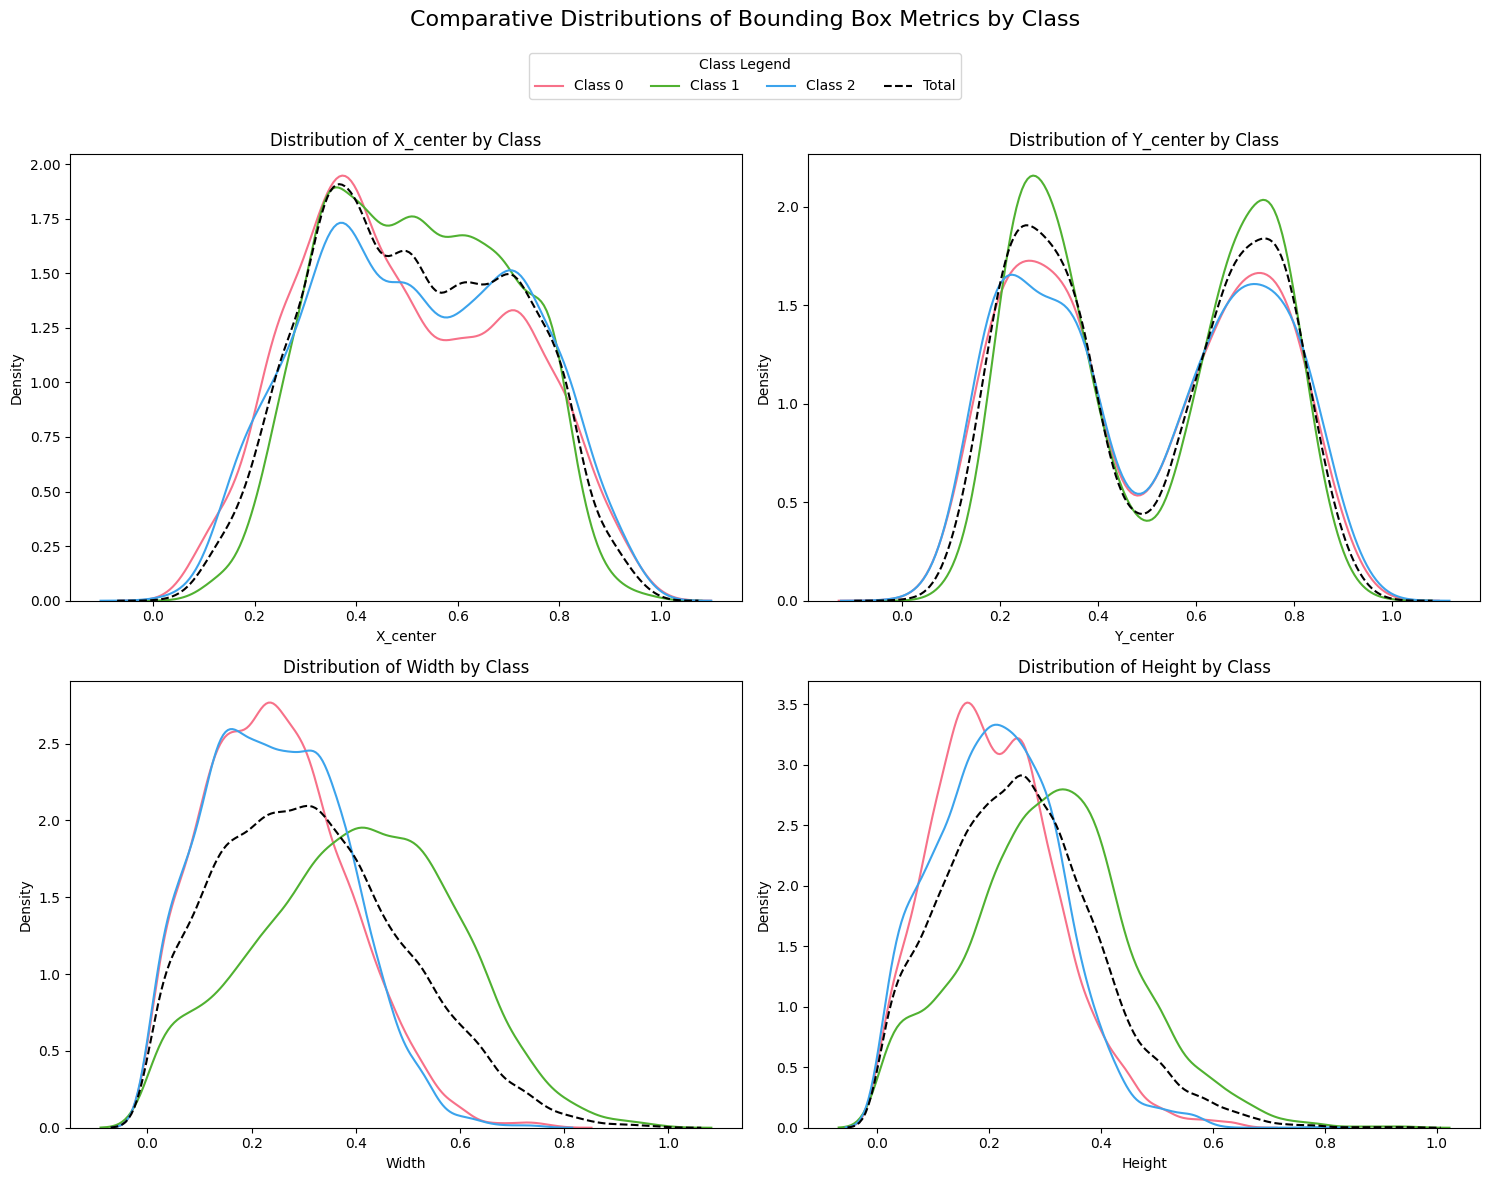

In [ ]:
# Function to plot distributions of x_center, y_center, width, height for each class
def plot_distributions_by_class(df):
    metrics = ['x_center', 'y_center', 'width', 'height']
    unique_classes = sorted(df['class_id'].unique())  # Sort class IDs for ordered legend
    
    # Initialize a 2x2 grid plot for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Comparative Distributions of Bounding Box Metrics by Class", fontsize=16)
    
    # Color palette for consistency
    palette = sns.color_palette("husl", len(unique_classes))
    
    # Iterate through metrics to plot
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]  # Determine the position in a 2x2 grid
        
        # Plot the distribution of the metric for each class_id
        for idx, class_id in enumerate(unique_classes):
            sns.kdeplot(df[df['class_id'] == class_id][metric], ax=ax, 
                        color=palette[idx], label=f'Class {class_id}' if i == 0 else "")
        
        # Plot total distribution across all classes for reference
        sns.kdeplot(df[metric], ax=ax, color='black', linestyle='--', label='Total' if i == 0 else "")
        
        # Set titles and labels
        ax.set_title(f'Distribution of {metric.capitalize()} by Class')
        ax.set_xlabel(metric.capitalize())
        ax.set_ylabel('Density')

    # Add a single legend outside the subplots, sorted by class_id
    handles, labels = axes[0, 0].get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])  # Sort by label (class name)
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    
    fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
               ncol=len(unique_classes) + 1, title="Class Legend")
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to make room for the main title and legend
    plt.show()

# Call the function for plotting distributions
plot_distributions_by_class(train_df)


#### Distribution Analysis:

**Distribution of $X_{\text{center}}$ by Class**:  
The $X_{\text{center}}$ distribution shows that horizontal centers are mostly concentrated between 0.1 and 0.8, with each class demonstrating slight variations. Class 1 displays a more left-centered distribution with a peak around 0.2, while Classes 0 and 2 follow similar but slightly different shapes. This suggests that objects in Class 1 are generally positioned more towards the left side of the frame. The overall similarity in distribution shapes indicates commonalities across classes, but the differences in peak positions may reflect subtle distinctions in object placement.

**Distribution of $Y_{\text{center}}$ by Class**:  
The $Y_{\text{center}}$ metric has a pronounced bimodal distribution across all classes, with peaks near 0.2 and 0.8. Class 1 shows the highest peaks at both positions, suggesting a strong preference for objects in this class to be located near the top or bottom of the frame. This consistent vertical pattern across classes implies that objects are often positioned in two distinct areas within the image, potentially indicating structural layout patterns. Class 1's prominent peaks also suggest more consistent object placements in this class compared to the others.

**Distribution of Width by Class**:  
Width distributions vary significantly by class, with Class 0 featuring a high-density peak at smaller width values around 0.2, indicating narrower objects. Class 1’s peak is slightly higher, around 0.3, but has a broader spread than Class 0. Class 2 shows a more diverse range of widths with a lower density peak, indicating that objects in this class come in a variety of sizes. This range highlights that Class 2 likely represents more variability in object sizes, which could influence how the model learns size-based distinctions across classes.

**Distribution of Height by Class**:  
The height distributions similarly show that smaller height values are more common, particularly around 0.2. Class 0 has a high-density peak at smaller heights, indicating that its objects tend to be shorter. Class 2, on the other hand, has a broader distribution, suggesting more variability in object height within this class. The dashed total line aligns closely with Class 1’s distribution, implying that Class 1’s height distribution may be representative of the overall dataset. This variability across classes in height distribution may affect the model’s interpretation of object height distinctions.
